In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="httplib2 transport does not support per-request timeout",
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee, os, math
import geemap

/opt/conda/envs/gee/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
PROJECT = 'eeps-geospatial'
ee.Initialize(project=PROJECT)
print("EE initialized.")

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


EE initialized.


In [3]:
ASSET   = 'projects/eeps-geospatial/assets/alaska_lakes'
BUCKET  = 'wustl-eeps-geospatial'
YEAR    = 2024
LAKE_ID_FIELD = 'id'            # from your properties
EXPORT_PREFIX = f'exports/Alaska_Lakes_IceDates_{YEAR}'

## Part 1: Export buffered lake data

Recalculate geometry for each area using EPSG:3338 (Alaska equal-area CRS)

In [4]:
# Original lakes FC
lakes = ee.FeatureCollection('projects/eeps-geospatial/assets/alaska_lakes')

# Alaska Albers Equal Area
proj_ak = ee.Projection('EPSG:3338')

def add_geom_props(feat):
    geom = feat.geometry()
    
    # Recompute total-lake metrics in EPSG:3338
    area_total = geom.area(maxError=1, proj=proj_ak)        # m²
    peri_total = geom.perimeter(maxError=1, proj=proj_ak)   # m
    
    # Compactness = 4πA / P², guard against P=0
    compact = ee.Algorithms.If(
        peri_total.gt(0),
        area_total.multiply(4 * math.pi).divide(peri_total.pow(2)),
        None
    )
    
    # Keep everything that was there, add new fields
    return feat.set({
        'area_m2_3338_total': area_total,
        'perim_m_3338_total': peri_total,
        'compact_3338_total': compact
    })

lakes_with_geom = lakes.map(add_geom_props)

Create the lake edge buffer - keep central 2/3 of each lake area

In [5]:
INNER_FRACTION = 0.67  # keep central ~67% of area

# Alaska Albers projection (EPSG:3338)
proj_ak = ee.Projection('EPSG:3338')

def area_fraction_buffer(feat):
    geom = feat.geometry()
    
    # Area in EPSG:3338 (m²)
    area = geom.area(maxError=1, proj=proj_ak)
    
    # Treat lake as roughly circular: A ≈ π r² → r ≈ sqrt(A/π)
    pi = ee.Number(math.pi)
    radius_equiv = area.divide(pi).sqrt()  # meters
    
    # Shrink radius by sqrt(INNER_FRACTION) so area shrinks by INNER_FRACTION
    inner_fraction_sqrt = ee.Number(INNER_FRACTION).sqrt()
    target_radius = radius_equiv.multiply(inner_fraction_sqrt)
    
    # Inward buffer distance ≈ (r_full - r_target)
    inner_dist = radius_equiv.subtract(target_radius)  # meters
    
    # Negative buffer = shrink geometry
    buffered = geom.buffer(inner_dist.multiply(-1))
    
    # Fallback if the buffer collapses or becomes empty
    buffered_geom = ee.Geometry(buffered)
    buffered_geom = ee.Algorithms.If(
        buffered_geom.area(maxError=1).gt(0),
        buffered_geom,
        geom  # fall back to full lake
    )
    
    return feat.setGeometry(ee.Geometry(buffered_geom))

# Apply to your lake collection
lakes_buf = lakes_with_geom.map(area_fraction_buffer)

In [6]:

m = geemap.Map(center=[70.5, -149.5], zoom=9, basemap='CartoDB.Positron')
m.addLayer(lakes.style(color='black', width=1, fillColor='00000000'), {}, 'Lakes original')
m.addLayer(lakes_buf.style(color='red', width=1, fillColor='00000000'), {}, 'Lakes buffered adaptive')
m

Map(center=[70.5, -149.5], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

Define Feature collection

In [7]:
def s1_collection(geom, year):
    start = ee.Date.fromYMD(year, 1, 1)
    end   = start.advance(1, 'year')
    coll = (ee.ImageCollection('COPERNICUS/S1_GRD')
            .filterBounds(geom)
            .filterDate(start, end)
            .filter(ee.Filter.eq('instrumentMode','IW'))
            .filter(ee.Filter.eq('orbitProperties_pass','ASCENDING'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VH'))  # ADD THIS
            .filter(ee.Filter.eq('resolution_meters',10)))
    def prep(img):
        angle = img.select('angle')
        angle_mask = angle.gt(30).And(angle.lt(45))
        
        # Process VV
        vv_lin = ee.Image(10.0).pow(img.select('VV').divide(10.0)).updateMask(angle_mask)
        vv_lin_f = vv_lin.focal_mean(1)
        vv_db = vv_lin_f.log10().multiply(10).rename('VV_db')
        
        # Process VH (ADD THIS BLOCK)
        vh_lin = ee.Image(10.0).pow(img.select('VH').divide(10.0)).updateMask(angle_mask)
        vh_lin_f = vh_lin.focal_mean(1)
        vh_db = vh_lin_f.log10().multiply(10).rename('VH_db')
        
        # Combine both bands
        return vv_db.addBands(vh_db).copyProperties(img, img.propertyNames()).set('system:time_start', img.get('system:time_start'))
    return coll.map(prep)

s1 = s1_collection(lakes.geometry(), YEAR)
print('S1 images:', s1.size().getInfo())

S1 images: 29


In [12]:
# Build per-lake, per-date VV/VH dB time series via reduceRegions,
# preserving all original properties and adding geometry / buffer metrics.

import math

SCALE = 10  # Sentinel-1 GRD resolution in meters

def image_to_features(img):
    # Make sure we only use the VV/VH dB bands
    vv_img = img.select('VV_db')
    vh_img = img.select('VH_db')

    # Date string for this acquisition
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')

    # Separate reducers for VV and VH
    vv_reducer = ee.Reducer.mean().combine(ee.Reducer.count(), sharedInputs=True)
    vh_reducer = ee.Reducer.mean()

    # Reduce VV over all buffered lakes
    vv_stats = vv_img.reduceRegions(
        collection = lakes_buf,
        reducer    = vv_reducer,
        scale      = SCALE,
        tileScale  = 2,
    )
    
    # Reduce VH over all buffered lakes
    vh_stats = vh_img.reduceRegions(
        collection = lakes_buf,
        reducer    = vh_reducer,
        scale      = SCALE,
        tileScale  = 2,
    )

    # Attach metadata and geometry metrics
    def add_metadata(f):
        # Original shapefile ID (e.g. 'id')
        lake_id_prop = f.get(LAKE_ID_FIELD)

        # Get corresponding VH stats for this lake
        vh_feature = vh_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        vh_mean_db = ee.Number(vh_feature.get('mean'))

        # Look up the original, unbuffered feature for full-lake metrics
        orig = lakes_with_geom.filter(
            ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)
        ).first()

        # Full-lake geometry in EPSG:3338 (fallback to current geom if not found)
        geom_full = ee.Algorithms.If(
            orig,
            ee.Feature(orig).geometry(),
            f.geometry()
        )
        geom_full = ee.Geometry(geom_full).transform(proj_ak, 1)
        area_full  = geom_full.area(1)       # m²
        perim_full = geom_full.perimeter(1)  # m

        # Buffer geometry metrics (geometry used for VV/VH reduction)
        buf_geom  = f.geometry().transform(proj_ak, 1)
        buf_area  = buf_geom.area(1)         # m²
        buf_perim = buf_geom.perimeter(1)    # m

        # Compactness (0–1, 1 = perfect circle) for full lake
        compact_full = (
            ee.Number(area_full)
            .multiply(4.0 * math.pi)
            .divide(ee.Number(perim_full).pow(2))
        )

        # Pixel count inside the buffer from the VV reducer
        pix_count = f.get('count')

        # Mean VV in dB from reduceRegions
        vv_mean_db = ee.Number(f.get('mean'))

        return (f
            # time / backscatter
            .set('date', date_str)
            .set('Year', YEAR)
            .set('vv_db', vv_mean_db)
            .set('vh_db', vh_mean_db)

            # full-lake metrics in EPSG:3338
            .set('lake_area_m2_3338',  area_full)
            .set('lake_perim_m_3338',  perim_full)
            .set('compact_3338_total', compact_full)

            # buffer metrics in EPSG:3338
            .set('buf_area_m2_3338',   buf_area)
            .set('buf_perim_m_3338',   buf_perim)
            .set('pix_count_buf',      pix_count)

            # integer lake ID for CSV / pandas
            .set('lake_id', ee.Number(lake_id_prop).toInt())
        )

    return vv_stats.map(add_metadata)

# Map over all S1 images → nested FeatureCollections → flatten into one big FC
nested  = s1.map(image_to_features)
lake_ts = ee.FeatureCollection(nested).flatten()

In [13]:
EXPORT_PREFIX = f'exports/Alaska_Lakes_S1timeseries_{YEAR}'

cols = [
    'lake_id',          
    'Year',
    'date',
    'vv_db',
    'vh_db',

    # Original shapefile attributes (carried through from LAKES)
    'Shape_Area',
    'Shape_Leng',
    'area',
    'circularit',
    'lat',
    'lon',
    'perimeter',

    # New geometry / buffer metrics (from the reducer cell)
    'lake_area_m2_3338',
    'lake_perim_m_3338',
    'lake_length_m_3338',
    'lake_width_m_3338',
    'compact_3338_total',
    'shape_index_3338_total',
    'fractal_dim_3338_total',
    'buf_area_m2_3338',
    'buf_perim_m_3338',
    'pix_count_buf',
]

task = ee.batch.Export.table.toCloudStorage(
    collection     = lake_ts.select(cols),
    description    = f'Alaska_Lakes_S1timeseries_{YEAR}',
    bucket         = BUCKET,
    fileNamePrefix = EXPORT_PREFIX,
    fileFormat     = 'CSV',
    selectors      = cols,
)
task.start()
print('Started export task:', task.id)

Started export task: AASX4FBPBVR3VW5NLRBBMD5Z


## Part 2: Process exported csv

In [23]:
!gsutil cp gs://wustl-eeps-geospatial/exports/Alaska_Lakes_S1timeseries_2024.csv .

Copying gs://wustl-eeps-geospatial/exports/Alaska_Lakes_S1timeseries_2024.csv...
/ [1 files][  3.8 MiB/  3.8 MiB]                                                
Operation completed over 1 objects/3.8 MiB.                                      


In [12]:
csv_path = "Alaska_Lakes_S1timeseries_2024.csv"
df = pd.read_csv(csv_path)

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# If lake_id is missing for any reason, rebuild it from id
if 'lake_id' not in df.columns:
    df['lake_id'] = df['id'].round().astype('Int64')

# Dual-pol features
df['vv_lin'] = 10.0 ** (df['vv_db'] / 10.0)
df['vh_lin'] = 10.0 ** (df['vh_db'] / 10.0)

df['vv_minus_vh_db'] = df['vv_db'] - df['vh_db']
df['vv_vh_ratio_lin'] = df['vv_lin'] / df['vh_lin'].replace(0, np.nan)

            id  Year       date      vv_db  Shape_Area  Shape_Leng  \
211   495091.0  2024 2024-01-05 -14.097730  1173.47666   160.49994   
752   495091.0  2024 2024-01-29 -15.017001  1173.47666   160.49994   
1293  495091.0  2024 2024-02-22 -16.563854  1173.47666   160.49994   
1834  495091.0  2024 2024-03-05 -16.242330  1173.47666   160.49994   
2375  495091.0  2024 2024-03-17 -16.443190  1173.47666   160.49994   

             area  circularit        lat         lon  ...  lake_perim_m_3338  \
211   1173.475055    0.572686  70.516579 -151.942347  ...         160.956756   
752   1173.475055    0.572686  70.516579 -151.942347  ...         160.956756   
1293  1173.475055    0.572686  70.516579 -151.942347  ...         160.956756   
1834  1173.475055    0.572686  70.516579 -151.942347  ...         160.956756   
2375  1173.475055    0.572686  70.516579 -151.942347  ...         160.956756   

      lake_length_m_3338  lake_width_m_3338  compact_3338_total  \
211                  NaN       

In [13]:
def process_lake(g, run_len=2,
                 spring_months=(3, 7),
                 fall_months=(8, 12)):
    """
    g: DataFrame for a single lake (one 'id')
    run_len: how many consecutive images to require for a valid state
    spring_months: (start, end) for break-up search
    fall_months: (start, end) for freeze-up search
    """
    g = g.sort_values('date').reset_index(drop=True)

    # Skip lakes with no valid VV
    if g['vv_db'].isna().all():
        return pd.Series({
            'Year': g['Year'].iloc[0] if 'Year' in g else np.nan,
            'threshold_vv_db': np.nan,
            'Last_Full_Ice_Day': pd.NaT,
            'First_No_Ice_Day': pd.NaT,
            'Last_No_Ice_Day': pd.NaT,
            'First_Full_Ice_Day': pd.NaT,
        })

    # Lake-specific threshold
    q20, q80 = g['vv_db'].quantile([0.2, 0.8])
    thr = 0.5 * (q20 + q80)

    # 1 = ice, 0 = open water
    g['state_raw'] = (g['vv_db'] >= thr).astype(int)

    # Rolling median over 3 images to smooth noise
    g['state'] = (
        g['state_raw']
        .rolling(window=3, center=True, min_periods=1)
        .median()
        .round()
        .astype(int)
    )

    g['month'] = g['date'].dt.month

    def first_run(month_min, month_max, target_state, run_len):
        """First date with >= run_len consecutive target_state in the given month window."""
        sub = g[(g['month'] >= month_min) & (g['month'] <= month_max)].copy()
        if sub.empty:
            return pd.NaT

        mask = (sub['state'] == target_state)
        arr = mask.to_numpy().astype(int)
        if arr.size < run_len:
            return pd.NaT

        conv = np.convolve(arr, np.ones(run_len, dtype=int), mode='valid')
        hits = np.where(conv == run_len)[0]
        if hits.size == 0:
            return pd.NaT

        # index of the first image in the first valid run
        first_idx = sub.index[hits[0]]
        return g.loc[first_idx, 'date']

    # Parameters
    spring_start, spring_end = spring_months
    fall_start, fall_end = fall_months

    # Break-up: open water (state=0) run in spring
    first_no_ice = first_run(spring_start, spring_end, target_state=0, run_len=run_len)

    # Freeze-up: ice (state=1) run in fall
    first_full_ice = first_run(fall_start, fall_end, target_state=1, run_len=run_len)

    # Last full ice day: last ice date before the break-up date
    if pd.isna(first_no_ice):
        last_full_ice = pd.NaT
    else:
        mask = (g['date'] < first_no_ice) & (g['state'] == 1)
        last_full_ice = g.loc[mask, 'date'].max() if mask.any() else pd.NaT

    # Last no-ice day: last water date in fall before freeze-up
    if pd.isna(first_full_ice):
        last_no_ice = pd.NaT
    else:
        mask = (
            (g['date'] < first_full_ice) &
            (g['state'] == 0) &
            (g['month'] >= fall_start)
        )
        last_no_ice = g.loc[mask, 'date'].max() if mask.any() else pd.NaT

    return pd.Series({
        'Year': g['Year'].iloc[0] if 'Year' in g else 2024,
        'threshold_vv_db': thr,
        'Last_Full_Ice_Day': last_full_ice,
        'First_No_Ice_Day': first_no_ice,
        'Last_No_Ice_Day': last_no_ice,
        'First_Full_Ice_Day': first_full_ice,
    })

In [18]:
summary = (
    df
    .groupby('lake_id', group_keys=False)
    .apply(process_lake, run_len=2)  # or 3 if you want stricter runs
    .reset_index()
)

summary.head()
df_events = summary

/var/tmp/ipykernel_159621/4236532723.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df


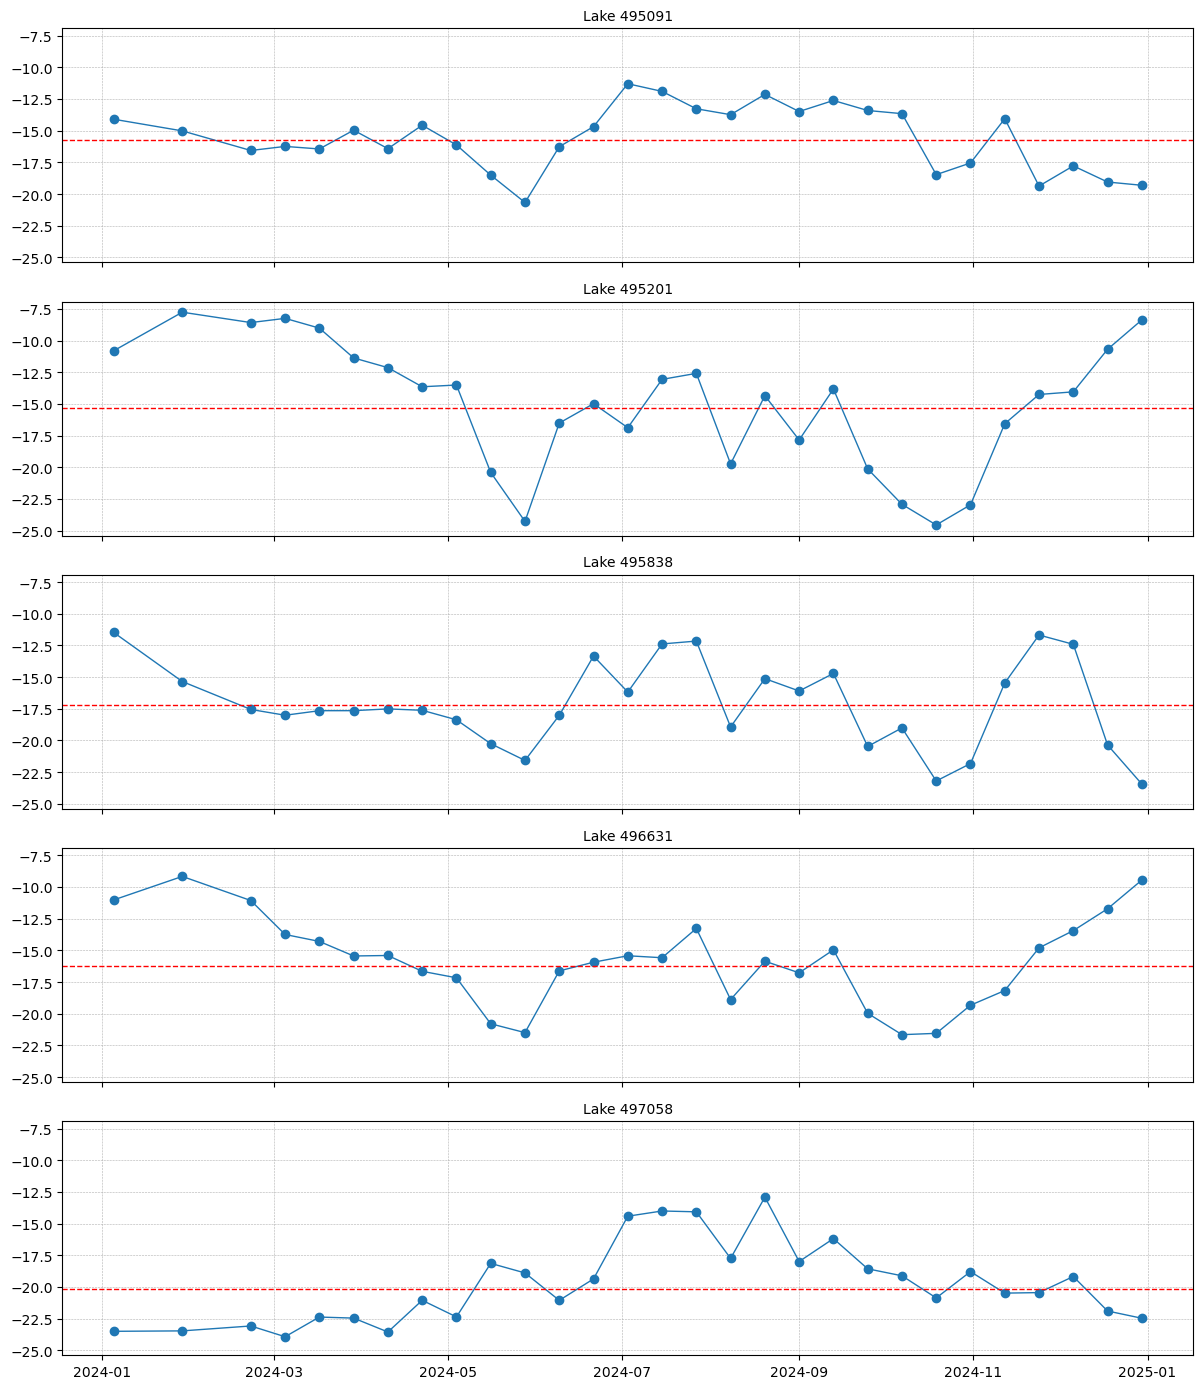

In [23]:
# Make sure date is datetime in the time-series dataframe
df['date'] = pd.to_datetime(df['date'])

# Make sure we have lake_id as an integer
if 'lake_id' not in df.columns:
    df['lake_id'] = df['id'].round().astype('Int64')

# If the summary table exists, rename it to df_events
df_events = summary.copy()

# Make sure lake_id exists there too
if 'lake_id' not in df_events.columns:
    df_events['lake_id'] = df_events['id'].round().astype('Int64')

# Pick the first 5 lakes
lake_ids = df_events['lake_id'].iloc[:5].tolist()

sub = df[df['lake_id'].isin(lake_ids)]

fig, axes = plt.subplots(5, 1, figsize=(12, 14), sharex=True, sharey=True)
axes = axes.flatten()

for ax, lake_id in zip(axes, lake_ids):
    g = sub[sub['lake_id'] == lake_id].sort_values('date')

    ax.plot(g['date'], g['vv_db'], marker='o', linewidth=1)

    # Lake-specific threshold
    thr = df_events.loc[df_events['lake_id'] == lake_id, 'threshold_vv_db'].iloc[0]
    ax.axhline(thr, color='red', linestyle='--', linewidth=1)

    ax.set_title(f"Lake {lake_id}", fontsize=10)
    ax.grid(True, linestyle='--', linewidth=0.4)

plt.tight_layout()
plt.show()

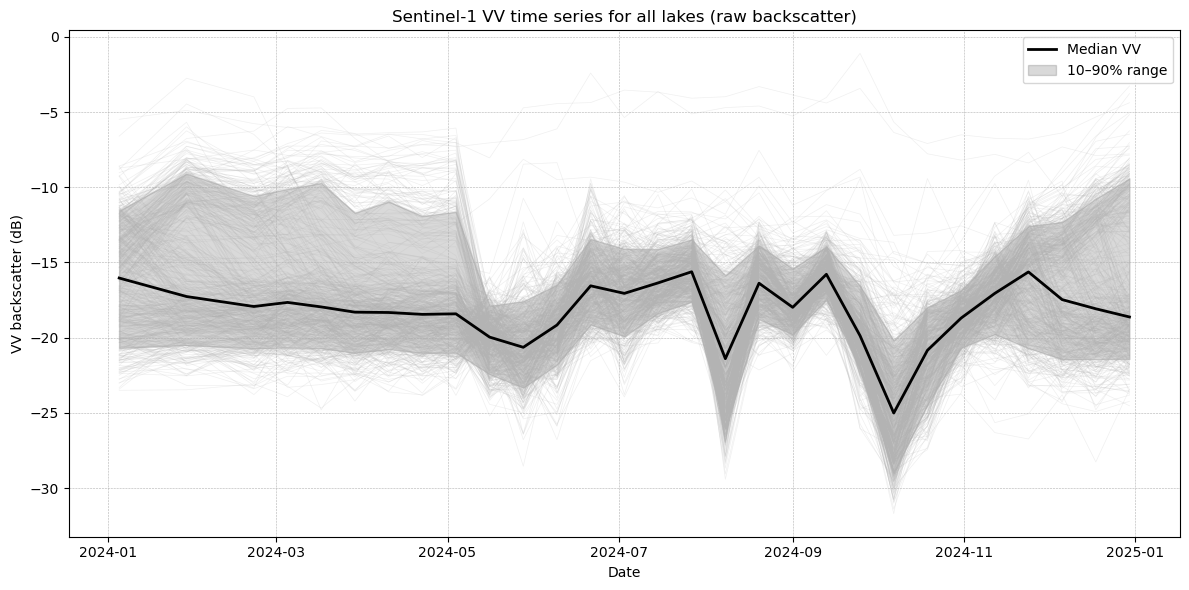

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Make sure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Decide which column is the lake identifier
id_col = 'lake_id' if 'lake_id' in df.columns else 'id'

# Sort for nicer plotting
df = df.sort_values(['date', id_col])

# Aggregate across lakes for each date
# You can switch to 'mean' if you prefer, but median is often more robust.
daily = (
    df.groupby('date')['vv_db']
      .agg(
          mean   = 'mean',
          median = 'median',
          p10    = lambda x: x.quantile(0.10),
          p90    = lambda x: x.quantile(0.90),
      )
      .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each lake's time series in light grey
for lake_id, g in df.groupby(id_col):
    ax.plot(
        g['date'],
        g['vv_db'],
        color='0.7',
        alpha=0.2,
        linewidth=0.5,
    )

# Plot the ensemble median as a darker line
ax.plot(
    daily['date'],
    daily['median'],
    color='black',
    linewidth=2,
    label='Median VV'
)

# Add an uncertainty band (10–90 percentile)
ax.fill_between(
    daily['date'],
    daily['p10'],
    daily['p90'],
    color='black',
    alpha=0.15,
    label='10–90% range'
)

ax.set_xlabel('Date')
ax.set_ylabel('VV backscatter (dB)')
ax.set_title('Sentinel-1 VV time series for all lakes (raw backscatter)')
ax.grid(True, linestyle='--', linewidth=0.4)

# Build a simple legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()
plt.show()

fig.savefig("all_lakes_raw_timeseries.png",
            dpi=300,
            bbox_inches="tight")

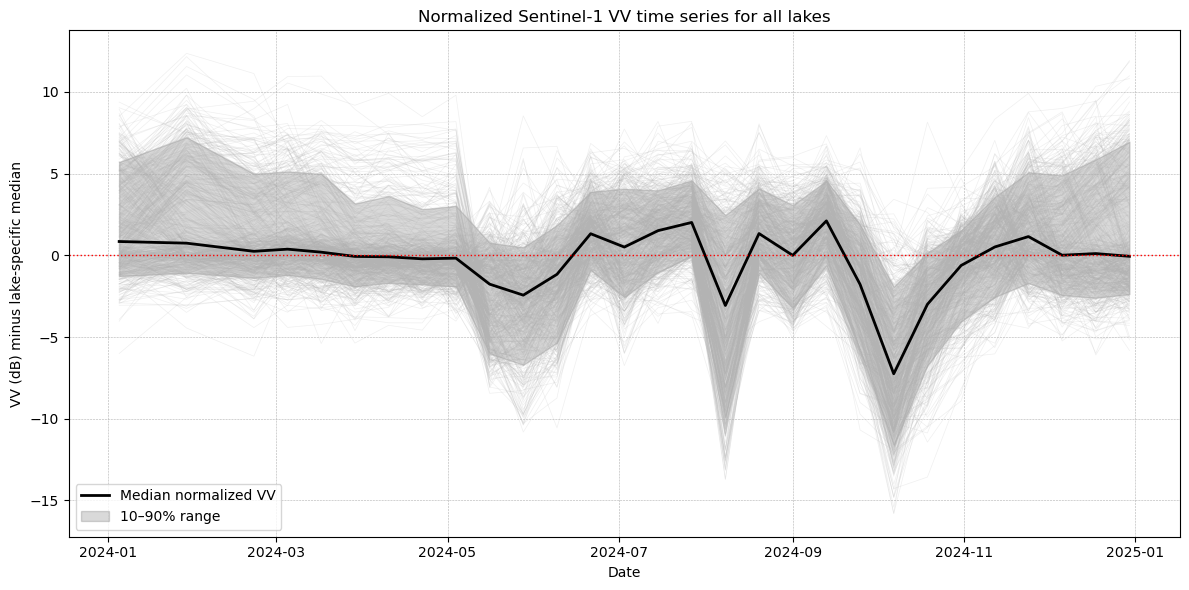

In [26]:
#now the same thing but normalized to each lake's median VV backscatter

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Decide which column is the lake identifier
id_col = 'lake_id' if 'lake_id' in df.columns else 'id'

# Work on a copy
df_norm = df.copy()

# Per-lake median VV, then subtract to center each lake
lake_medians = df_norm.groupby(id_col)['vv_db'].transform('median')
df_norm['vv_norm'] = df_norm['vv_db'] - lake_medians

# Sort for nicer plotting
df_norm = df_norm.sort_values(['date', id_col])

# Aggregate across lakes for each date (normalized VV)
daily_norm = (
    df_norm.groupby('date')['vv_norm']
           .agg(
               mean   = 'mean',
               median = 'median',
               p10    = lambda x: x.quantile(0.10),
               p90    = lambda x: x.quantile(0.90),
           )
           .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each lake's normalized time series in light grey
for lake_id, g in df_norm.groupby(id_col):
    ax.plot(
        g['date'],
        g['vv_norm'],
        color='0.7',
        alpha=0.2,
        linewidth=0.5,
    )

# Plot the ensemble median of normalized VV
ax.plot(
    daily_norm['date'],
    daily_norm['median'],
    color='black',
    linewidth=2,
    label='Median normalized VV'
)

# Add an uncertainty band (10–90 percentile)
ax.fill_between(
    daily_norm['date'],
    daily_norm['p10'],
    daily_norm['p90'],
    color='black',
    alpha=0.15,
    label='10–90% range'
)

# Zero line for reference
ax.axhline(0, color='red', linestyle=':', linewidth=1)

ax.set_xlabel('Date')
ax.set_ylabel('VV (dB) minus lake-specific median')
ax.set_title('Normalized Sentinel-1 VV time series for all lakes')
ax.grid(True, linestyle='--', linewidth=0.4)

# Simple legend without duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()
plt.show()

fig.savefig("all_lakes_normalized_timeseries.png",
            dpi=300,
            bbox_inches="tight")

In [11]:
import ee, geemap
import pandas as pd

ee.Initialize(project='eeps-geospatial')

def show_sar_for_lake(lake_id, df_events, year=2024):
    # Get event row for this lake
    row = df_events[df_events['lake_id'] == lake_id].iloc[0]

    # Get lake geometry
    lake = lakes.filter(ee.Filter.eq('id', float(lake_id))).first()
    geom = lake.geometry()

    # Base map centered on lake
    m = geemap.Map(center=[row['lat'], row['lon']], zoom=11, basemap='CartoDB.Positron')
    m.addLayer(geom, {'color':'yellow'}, f'Lake {lake_id}')

    # Helper to fetch S1 image for a given date string
    def get_s1_for_date(date_str):
        start = ee.Date(date_str)
        end   = start.advance(1, 'day')
        col = (ee.ImageCollection('COPERNICUS/S1_GRD')
               .filterBounds(geom)
               .filterDate(start, end)
               .filter(ee.Filter.eq('instrumentMode', 'IW'))
               .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
               .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')))
        return col.first()

    events = [
        ('Last_Full_Ice_Day',  'Blues'),
        ('First_No_Ice_Day',   'Greens'),
        ('Last_No_Ice_Day',    'Oranges'),
        ('First_Full_Ice_Day', 'Purples'),
    ]

    for col_name, palette in events:
        d = row[col_name]
        if pd.isna(d):
            continue
        date_str = pd.to_datetime(d).strftime('%Y-%m-%d')
        img = get_s1_for_date(date_str)
        if img is None:
            continue  # no image that day

        vv = img.select('VV')
        m.addLayer(
            vv,
            {'min': -25, 'max': 0, 'palette': ['black', 'white']},
            f'{col_name} {date_str}'
        )

    return m

# Example: first lake from your 5
lake_id_example = df_events['lake_id'].iloc[0]
show_sar_for_lake(lake_id_example, df_events)

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


NameError: name 'df_events' is not defined